In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/MVA/RL/optimist/baselines/optimist/

/content/drive/MyDrive/MVA/RL/optimist/baselines/optimist


In [3]:
!pip install mpi4py
!pip install tensorflow==1.14

     |████████████████████████████████| 1.4MB 5.2MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp37-cp37m-linux_x86_64.whl size=2065184 sha256=301e13e34eefdda9d59ad43a30fe142fcfeaefc5d8133235182e18d58ad8050f
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py
     |████████████████████████████████| 109.3MB 88kB/s 
     |████████████████████████████████| 3.2MB 49.9MB/s 
     |████████████████████████████████| 491kB 34.7MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [4]:
# Common imports
import sys
sys.path.append('../../')

import re, os, time, logging
from collections import defaultdict

# Framework imports
import gym
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import random
import pickle
import numpy as np

# Self imports: utils
from baselines.common import set_global_seeds
from baselines import logger
import baselines.common.tf_util as U
from baselines.common.rllab_utils import Rllab2GymWrapper, rllab_env_from_name
from run import args_to_file, get_env_type
# Self imports: algorithm
from baselines.policy.mlp_hyperpolicy import PeMlpPolicy
from baselines.optimist import optimist
from arguments import get_args

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

no display found. Using non-interactive Agg backend


## Non-Conservative (Initial) logs

In [5]:
path = glob.glob('logs/*csv')
# path[-1] = 'logs/MOUNTAINCARCONTINUOUS-V0_delta=0.2_seed=1_9-35-5_222021_39015.csv'

In [6]:
results_original = pd.read_csv(path[-1])

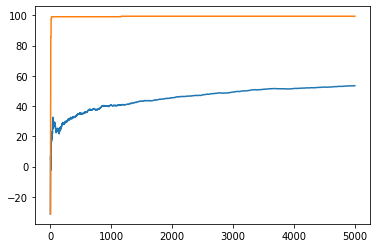

In [7]:
plt.figure()
plt.plot(results_original['ReturnMean'])
# plt.plot(results['ReturnLastEpisode'])
plt.plot(results_original['ReturnMax'])
plt.show()

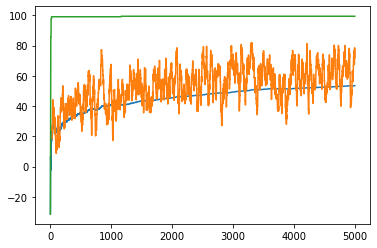

In [8]:
plt.figure()
plt.plot(results_original['ReturnMean'])
# plt.plot(results['ReturnLastEpisode'])
plt.plot(results_original['ReturnLastEpisode'].rolling(30).mean())
plt.plot(results_original['ReturnMax'])
plt.show()

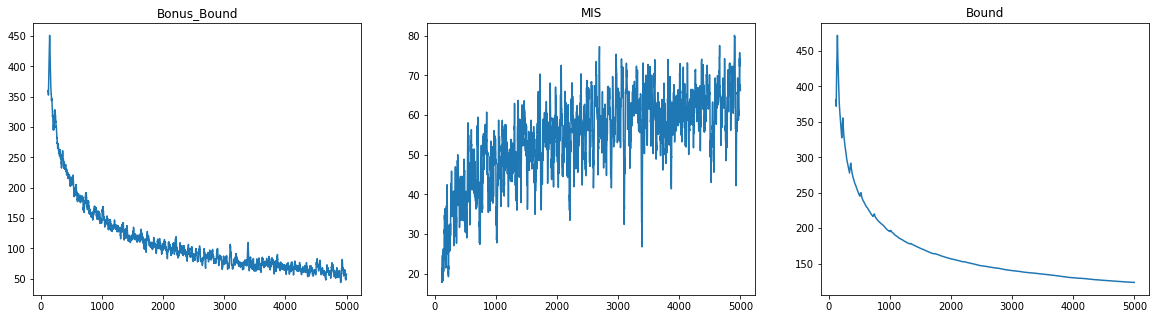

In [9]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1, title='Bonus_Bound')
plt.plot(results_original['BoundBonus'][100:].rolling(20).mean())
plt.subplot(1, 3, 2, title='MIS')
plt.plot(results_original['BoundMISE'][100:].rolling(20).mean())
plt.subplot(1, 3, 3, title='Bound')
plt.plot(results_original['Bound'][100:].rolling(20).mean())
plt.show()

## Conservative Logs

### Choose relevant logs

In [15]:
# Choose goot paths
paths = glob.glob('logs_conservative/*csv')

paths

['logs_conservative/MOUNTAINCARCONTINUOUS-V0_delta=0.2_seed=0_17-23-57_322021_13998.csv',
 'logs_conservative/MOUNTAINCARCONTINUOUS-V0_delta=0.2_seed=0_13-30-15_422021_17765.csv']

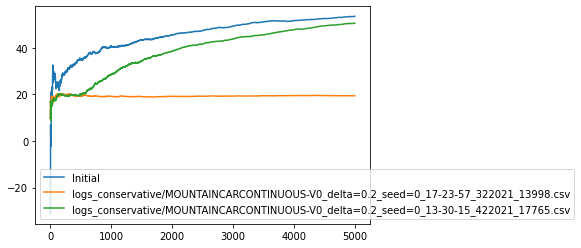

In [16]:
plt.plot(results_original['ReturnMean'], label='Initial')
for path in paths:
  results_conservative = pd.read_csv(path)
  plt.plot(results_conservative['ReturnMean'], label=path)
plt.legend()
plt.show()

### Plot relevant logs

In [17]:
chosen_path = 'logs_conservative/MOUNTAINCARCONTINUOUS-V0_delta=0.2_seed=0_13-30-15_422021_17765.csv'

results_conservative = pd.read_csv(chosen_path)
results_conservative.shape

(5000, 35)

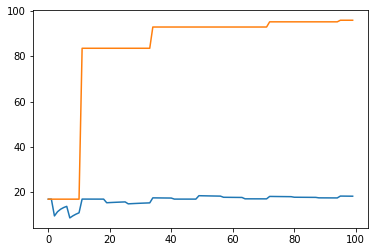

In [18]:
plt.figure()
plt.plot(results_conservative['ReturnMean'][:100])
# plt.plot(results['ReturnLastEpisode'])
plt.plot(results_conservative['ReturnMax'][:100])
plt.show()

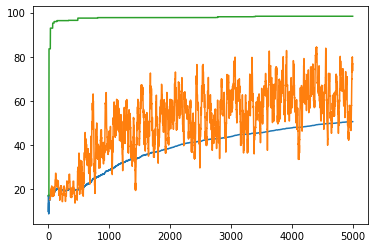

In [19]:
plt.figure()
plt.plot(results_conservative['ReturnMean'])
# plt.plot(results_conservative['ReturnLastEpisode'])
plt.plot(results_conservative['ReturnLastEpisode'].rolling(30).mean())
plt.plot(results_conservative['ReturnMax'])
plt.show()

In [ ]:
without_baseline = results_conservative.copy()
without_baseline = without_baseline[without_baseline.loc[:, 'ReturnLastEpisode'] != 16.931513]

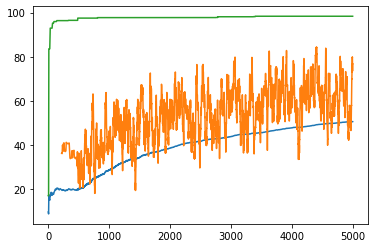

In [ ]:
plt.figure()
plt.plot(without_baseline['ReturnMean'])
# plt.plot(results['ReturnLastEpisode'])
plt.plot(without_baseline['ReturnLastEpisode'].rolling(30).mean())
plt.plot(without_baseline['ReturnMax'])
plt.show()

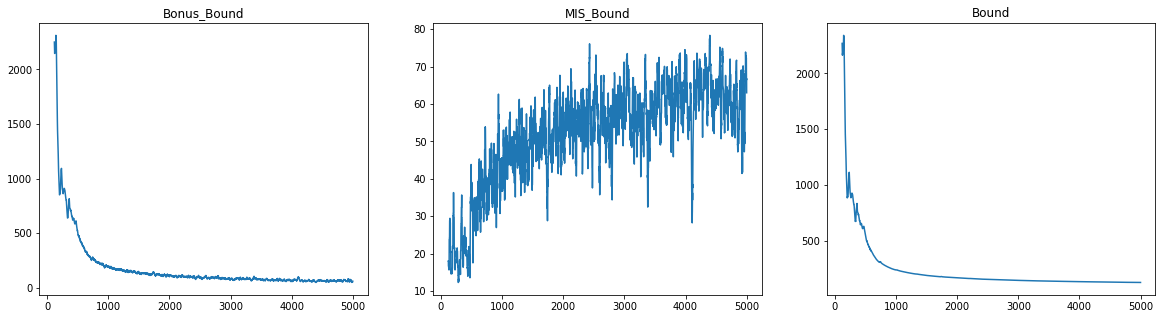

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1, title='Bonus_Bound')
plt.plot(results_conservative['BoundBonus'][100:].rolling(20).mean())
plt.subplot(1, 3, 2, title='MIS_Bound')
plt.plot(results_conservative['BoundMISE'][100:].rolling(20).mean())
plt.subplot(1, 3, 3, title='Bound')
plt.plot(results_conservative['Bound'][100:].rolling(20).mean())
plt.show()

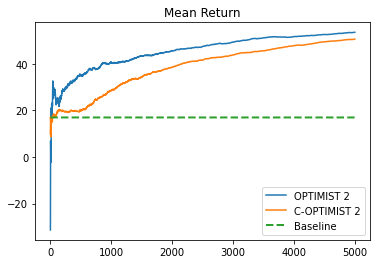

In [ ]:
plt.figure()
plt.plot(results_original['ReturnMean'], label='OPTIMIST 2')
plt.plot(results_conservative['ReturnMean'], label='C-OPTIMIST 2')
plt.plot([16.93 for i in range(results_conservative.shape[0])], \
      linestyle='--', linewidth=2, markersize=12, label='Baseline')
plt.title('Mean Return')
plt.legend()
plt.show()

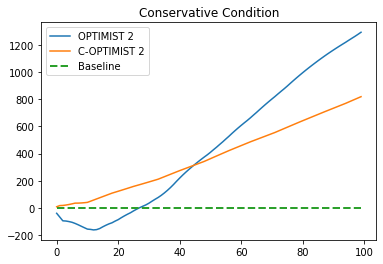

In [ ]:
RHS = 0.5 * np.cumsum([16.93 for i in range(100)])

plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(results_original['ReturnMean'][:100]) - RHS, label='OPTIMIST 2')
plt.plot(np.cumsum(results_conservative['ReturnMean'][:100]) - RHS, label='C-OPTIMIST 2')
plt.plot([0. for i in range(100)], \
      linestyle='--', linewidth=2, markersize=12, label='Baseline')
plt.title('Conservative Condition')
plt.legend()
plt.show()

## Initial C-OPTIMIST

In [21]:
conservative_init = pd.read_csv(paths[0])
conservative_init.shape

without_baseline = conservative_init.copy()
without_baseline = without_baseline[without_baseline.loc[:, 'ReturnLastEpisode'] != 16.931513]
height = conservative_init.copy()
height.loc[height['ReturnLastEpisode'] != 16.931513, :] = 10
height.loc[conservative_init['ReturnLastEpisode'] == 16.931513, :] = 0
height = height['ReturnLastEpisode']

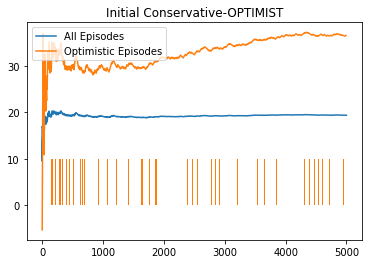

In [43]:
plt.figure()
plt.plot(conservative_init['ReturnMean'], label='All Episodes')
plt.plot(without_baseline['ReturnLastEpisode'].cumsum()/np.arange(1, without_baseline['ReturnLastEpisode'].shape[0]+1), label='Optimistic Episodes')
plt.bar(range(5000), height, color='tab:orange')
plt.title('Initial Conservative-OPTIMIST')
plt.legend()
plt.show()

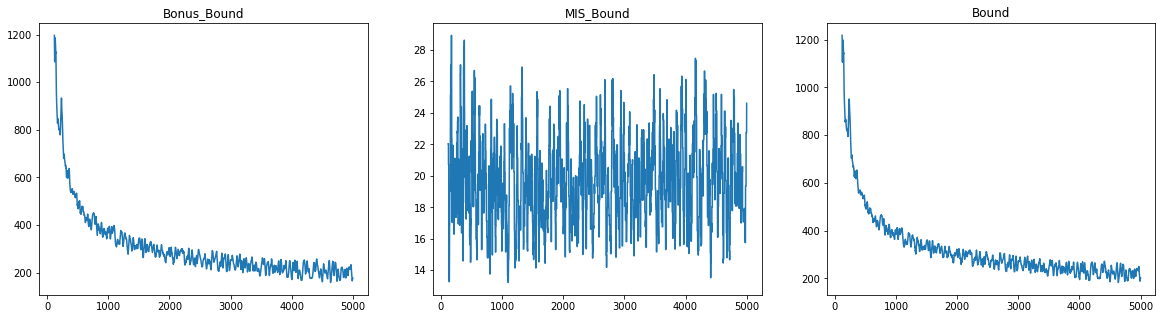

In [45]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1, title='Bonus_Bound')
plt.plot(conservative_init['BoundBonus'][100:].rolling(20).mean())
plt.subplot(1, 3, 2, title='MIS_Bound')
plt.plot(conservative_init['BoundMISE'][100:].rolling(20).mean())
plt.subplot(1, 3, 3, title='Bound')
plt.plot(conservative_init['Bound'][100:].rolling(20).mean())
plt.show()

## Find Baseline Policy

In [ ]:
def make_policy(name, ob_space, ac_space):
        return PeMlpPolicy(name, ob_space, ac_space, hid_layers,
                           deterministic=True, diagonal=True,
                           trainable_std=args.trainable_std,
                           use_bias=False, use_critic=False,
                           seed=seed, verbose=True,
                           hidden_W_init=U.normc_initializer(1.0),
                           higher_mean_init=higher_mean_init,
                           higher_logstd_init=higher_logstd_init,
                           const_std_init=const_std_init)
        
with open('checkpoints/checkpoint_250.pkl', 'rb') as f:
    weights = pickle.load(f)

In [ ]:
args = get_args()
def set_seeds(seed):
  tf.random.set_random_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

# Important args
env = args.env
policy = args.policy
seed = 1
set_seeds(seed)
mu_init = args.mu_init
std_init = args.std_init

# Normal gym, get if Atari or not.
env_type = get_env_type(env)
assert env_type is not None, "Env not recognized."
# Define the correct env maker
if env_type == 'atari':
    # Atari is not tested here
    raise Exception('Not tested on atari.')
else:
    # Not atari, standard env creation
    def make_env():
        env_rllab = gym.make(env)
        return env_rllab
env_name = make_env().spec.id

# Create the policy
if policy == 'linear':
    hid_layers = []
else:
    raise NotImplementedError

higher_mean_init = U.normc_initializer(1.0)
# higher_logstd_init = tf.constant_initializer(np.log(1e-2))
higher_logstd_init = tf.constant(np.log([0.15, 3]).astype(np.float32))
const_std_init = True

# Policy parameters
name = 'baseline_policy'
# Build the environment
env = make_env()
ob_space = env.observation_space
ac_space = env.action_space

env.seed(seed)

# Initialize session
try:
    affinity = len(os.sched_getaffinity(0))
except:
    affinity = njobs
sess = U.make_session(affinity)
sess.__enter__()

# Build the higher level target and behavioral policies
baseline_pi = make_policy(name, ob_space, ac_space)
baseline_pi.set_params(weights['higher'])
baseline_pi.set_actor_params(weights['lower'])






Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use `tf.cast` instead.


In [ ]:
ac1 = baseline_pi.eval_actor_mean([[1, 1]])[0][0]
mu1_higher = baseline_pi.eval_higher_mean()
sigma = baseline_pi.eval_higher_std()
ac1, mu1_higher, sigma

(17.660484,
 array([ 1., 20.], dtype=float32),
 array([0.14999999, 3.        ], dtype=float32))

In [ ]:
def eval_trajectory(env, pol, gamma, horizon, feature_fun, rescale_ep_return):
  ret = disc_ret = 0
  t = 0
  ob = env.reset()
  done = False
  # while not done and t < horizon:
  for t in range(horizon):
      if done:
          r = 0.01
          ret += r
          disc_ret += gamma**t * r
      else:
          s = feature_fun(ob) if feature_fun else ob
          a = pol.act(s)
          ob, r, done, _ = env.step(a)
          ob = np.reshape(ob, newshape=s.shape)
          ret += r
          disc_ret += gamma**t * r
          # t += 1
      if rescale_ep_return:
          # Rescale episodic return in [0, 1]
          if env.spec.id == 'LQG1D-v0':
              # Rescale episodic return in [0, 1]
              # (Hp: r takes values in [0, 1])
              ret = ret / horizon
              max_disc_ret = (1 - gamma**(horizon)) / (1 - gamma)
              disc_ret = disc_ret / max_disc_ret
          else:
              raise NotImplementedError
  return ret, disc_ret, t

In [ ]:
env = env
pol = baseline_pi
gamma = 1
horizon = 300
feature_fun = None
rescale_ep_return = False

eval_trajectory(env, pol, gamma, horizon, feature_fun, rescale_ep_return)

(90.14328822892638, 90.14328822892638, 299)

In [ ]:
with open('baseline/checkpoint.pkl', 'rb') as f:
    weights = pickle.load(f)
baseline_pi.set_params(weights['higher'])
baseline_pi.set_actor_params(weights['lower'])

evaluations = []

or i in range(200):
  baseline_pi.resample()
  return_, _, _ = eval_trajectory(env, baseline_pi, gamma, horizon, feature_fun, rescale_ep_return)
  evaluations.append(return_)f